In [2]:
import pandas as pd
pd.set_option('display.precision', 3)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

import os, sys
sys.path.append('./analysis/')

# import tqdm for notebooks
from tqdm.notebook import tqdm

# autoreload
%load_ext autoreload
%autoreload 2
import utils
from utils import SUBARXIV_NAMES_DICT, RECENT_DATE_THRESHOLD

## Establish list of first-time 2023 authors

Going to define 'first-time' as people who haven't previously written in cs.CL, using the whole arXiv corpus over the full date range.

In [3]:
arxiv_df = utils.load_all_metadata(full_date_range = True)

In [4]:
arxiv_df = arxiv_df.explode('authors').rename(columns={'authors': 'author'})
arxiv_df = arxiv_df.drop('versions', axis=1)
print(arxiv_df.shape)
display(arxiv_df.head(5))

(2183991, 9)


,id,author,title,categories,abstract,first_category,v1_date,LM_related_terms,mentions_LM_keyword
0,0704.0002,Ileana Streinu,Sparsity-certifying Graph Decompositions,"[math.CO, cs.CG]","We describe a new algorithm, the $(k,\ell)$-...",math.CO,2007-03-31 02:26:18,[],False
0,0704.0002,Louis Theran,Sparsity-certifying Graph Decompositions,"[math.CO, cs.CG]","We describe a new algorithm, the $(k,\ell)$-...",math.CO,2007-03-31 02:26:18,[],False
1,0704.0046,I. Csiszar,A limit relation for entropy and channel capac...,"[quant-ph, cs.IT, math.IT]","In a quantum mechanical model, Diosi, Feldma...",quant-ph,2007-04-01 16:37:36,[],False
1,0704.0046,F. Hiai,A limit relation for entropy and channel capac...,"[quant-ph, cs.IT, math.IT]","In a quantum mechanical model, Diosi, Feldma...",quant-ph,2007-04-01 16:37:36,[],False
1,0704.0046,D. Petz,A limit relation for entropy and channel capac...,"[quant-ph, cs.IT, math.IT]","In a quantum mechanical model, Diosi, Feldma...",quant-ph,2007-04-01 16:37:36,[],False


In [5]:
# Using arxiv_df, get a list of all authors who have ever published in cs.CL, along with the date of their first publication
# That is, get all the rows where "cs.CL" is an element of the list in the 'categories' column, and store the 'author' and 'v1_date' columns
# Then, group by 'author' and take the minimum 'v1_date' for each author
# Store each author in a dictionary, with the author as the key and the date as the value
nlp_authors_with_first_date = arxiv_df[arxiv_df['categories'].apply(lambda x: 'cs.CL' in x)].groupby('author')['v1_date'].min().to_dict()
print(len(nlp_authors_with_first_date))


69148


In [6]:
llm_df = utils.load_annotated_lm_metadata()
print(llm_df.shape)

# Replace the list of authors in the author column with only a string of the first author
llm_df['first_author'] = llm_df['authors'].apply(lambda x: x[0])
llm_df['last_author'] = llm_df['authors'].apply(lambda x: x[-1])

display(llm_df.head(5))

(16979, 19)


,id,authors,title,categories,abstract,versions,first_category,v1_date,LM_related_terms,mentions_LM_keyword,...,domains,industry,academic,above_pred_female_threshold,inferred_female_frac_nqg_uncertainty_threshold_0.100,citationCount,percentile_rank_in_3_month_window,percentile_rank_in_12_month_window,first_author,last_author
0,arXiv:1801.00409,"[Haris Bin Zia, Agha Ali Raza, Awais Athar]",PronouncUR: An Urdu Pronunciation Lexicon Gene...,[cs.CL],State-of-the-art speech recognition systems ...,"[{'version': 'v1', 'created': 'Mon, 1 Jan 2018...",cs.CL,2018-01-01 07:54:09,[language model],True,...,"[ebi.ac.uk, itu.edu.pk]",False,False,False,0.0,7.0,0.222,0.263,Haris Bin Zia,Awais Athar
1,arXiv:1801.00841,"[Kanishka Rao, Haşim Sak, Rohit Prabhavalkar]","Exploring Architectures, Data and Units For St...","[cs.CL, cs.SD, eess.AS]",We investigate training end-to-end speech re...,"[{'version': 'v1', 'created': 'Tue, 2 Jan 2018...",cs.CL,2018-01-02 21:29:41,[language model],True,...,[google.com],True,False,False,0.0,308.0,0.907,0.938,Kanishka Rao,Rohit Prabhavalkar
2,arXiv:1801.03844,"[Jibril Frej, Jean-Pierre Chevallet, Didier Sc...",Enhancing Translation Language Models with Wor...,[cs.IR],"In this paper, we explore the usage of Word ...","[{'version': 'v1', 'created': 'Thu, 11 Jan 201...",cs.IR,2018-01-11 16:08:27,[language model],True,...,"[imag.fr, univ-grenoble-alpes.fr]",False,True,False,0.0,7.0,0.222,0.263,Jibril Frej,Didier Schwab
3,arXiv:1801.06146,"[Jeremy Howard, Sebastian Ruder]",Universal Language Model Fine-tuning for Text ...,"[cs.CL, cs.LG, stat.ML]",Inductive transfer learning has greatly impa...,"[{'version': 'v1', 'created': 'Thu, 18 Jan 201...",cs.CL,2018-01-18 17:54:52,[language model],True,...,"[fast.ai, ruder.io]",False,False,False,0.0,252.0,0.870,0.912,Jeremy Howard,Sebastian Ruder
4,arXiv:1801.06271,"[Mario Linares-Vasquez, Martin White, Carlos B...",Mining Android App Usages for Generating Actio...,[cs.SE],GUI-based models extracted from Android app ...,"[{'version': 'v1', 'created': 'Fri, 19 Jan 201...",cs.SE,2018-01-19 02:21:57,[language model],True,...,[wm.edu],False,False,False,0.0,99.0,0.741,0.801,Mario Linares-Vasquez,Denys Poshyvanyk


In [7]:
# For each year, get the number of LLM first authors who had not published in cs.CL prior to their LLM paper
new_author_stat_dict = {
    'year': [],
    'n_papers': [],
    'new_first_authors_papercount': [],
    'new_last_authors_papercount': [],
    'n_unique_first_authors': [],
    'n_unique_last_authors': [],
    'new_first_authors_unique': [],
    'new_last_authors_unique': [],
}

for year in range(2018, 2024):
    llm_df_year = llm_df[llm_df['v1_date'].dt.year == year]
    new_author_stat_dict['year'].append(year)
    new_author_stat_dict['n_papers'].append(len(llm_df_year))
    new_author_stat_dict['n_unique_first_authors'].append(len(llm_df_year['first_author'].unique()))
    new_author_stat_dict['n_unique_last_authors'].append(len(llm_df_year['last_author'].unique()))

    new_first_authors = []
    new_last_authors = []
    for index, row in llm_df_year.iterrows():
        first_author = row['first_author']
        if first_author not in nlp_authors_with_first_date or (first_author in nlp_authors_with_first_date and nlp_authors_with_first_date[first_author] >= row['v1_date']):
            new_first_authors.append(first_author)

        last_author = row['last_author']
        if last_author not in nlp_authors_with_first_date or (last_author in nlp_authors_with_first_date and nlp_authors_with_first_date[last_author] >= row['v1_date']):
            new_last_authors.append(last_author)
    
    new_author_stat_dict['new_first_authors_papercount'].append(len(new_first_authors))
    new_author_stat_dict['new_last_authors_papercount'].append(len(new_last_authors))

    new_author_stat_dict['new_first_authors_unique'].append(len(set(new_first_authors)))
    new_author_stat_dict['new_last_authors_unique'].append(len(set(new_last_authors)))

new_author_stat_df = pd.DataFrame(new_author_stat_dict)
new_author_stat_df['%_new_first_author_papers'] = new_author_stat_df['new_first_authors_papercount'] / new_author_stat_df['n_papers'] * 100
new_author_stat_df['%_new_last_author_papers'] = new_author_stat_df['new_last_authors_papercount'] / new_author_stat_df['n_papers'] * 100
new_author_stat_df['%_new_first_author_unique'] = new_author_stat_df['new_first_authors_unique'] / new_author_stat_df['n_unique_first_authors'] * 100
new_author_stat_df['%_new_last_author_unique'] = new_author_stat_df['new_last_authors_unique'] / new_author_stat_df['n_unique_last_authors'] * 100
display(new_author_stat_df)

,year,n_papers,new_first_authors_papercount,new_last_authors_papercount,n_unique_first_authors,n_unique_last_authors,new_first_authors_unique,new_last_authors_unique,%_new_first_author_papers,%_new_last_author_papers,%_new_first_author_unique,%_new_last_author_unique
0,2018,337,170,107,310,288,167,102,50.445,31.751,53.871,35.417
1,2019,1098,438,247,983,794,436,244,39.891,22.495,44.354,30.730
2,2020,2153,882,526,1912,1518,875,520,40.966,24.431,45.764,34.256
3,2021,2992,1188,686,2645,2083,1175,673,39.706,22.928,44.423,32.309
4,2022,3972,1434,776,3433,2585,1400,751,36.103,19.537,40.781,29.052
5,2023,6427,2853,1747,5542,4288,2746,1658,44.391,27.182,49.549,38.666


/tmp/ipykernel_4106258/1856666540.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


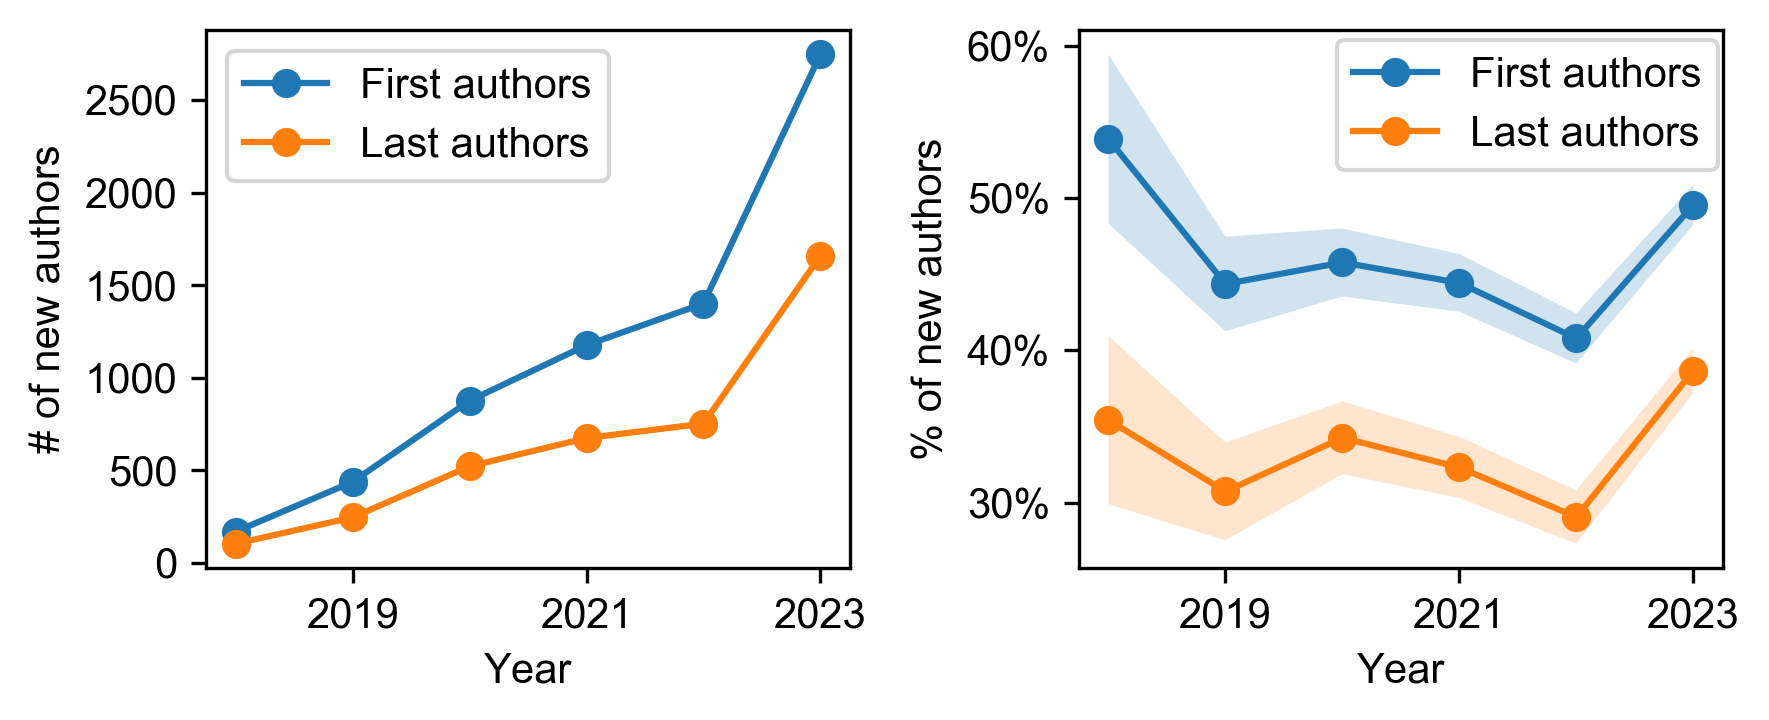

In [17]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 2.5), dpi=300)

axs[0].plot(new_author_stat_df['year'], new_author_stat_df['new_first_authors_unique'], label='First authors', marker='o')
axs[0].plot(new_author_stat_df['year'], new_author_stat_df['new_last_authors_unique'], label='Last authors', marker='o')

axs[0].set_xticks(np.arange(2019, 2024, 2))

axs[0].set_xlabel('Year')
axs[0].set_ylabel('# of new authors')
axs[0].legend()

col_first_author = '%_new_first_author_unique'
col_last_author = '%_new_last_author_unique'
col_first_author_total = 'n_unique_first_authors'
col_last_author_total = 'n_unique_last_authors'

axs[1].plot(new_author_stat_df['year'], new_author_stat_df[col_first_author], label='First authors', marker='o')
axs[1].plot(new_author_stat_df['year'], new_author_stat_df[col_last_author], label='Last authors', marker='o')
# 95% confidence interval
axs[1].fill_between(new_author_stat_df['year'], 
                    new_author_stat_df[col_first_author] - 1.96 * np.sqrt(new_author_stat_df[col_first_author] * (100 - new_author_stat_df[col_first_author]) / new_author_stat_df[col_first_author_total]), 
                    new_author_stat_df[col_first_author] + 1.96 * np.sqrt(new_author_stat_df[col_first_author] * (100 - new_author_stat_df[col_first_author]) / new_author_stat_df[col_first_author_total]), alpha=0.2)
axs[1].fill_between(new_author_stat_df['year'],
                    new_author_stat_df[col_last_author] - 1.96 * np.sqrt(new_author_stat_df[col_last_author] * (100 - new_author_stat_df[col_last_author]) / new_author_stat_df[col_last_author_total]),
                    new_author_stat_df[col_last_author] + 1.96 * np.sqrt(new_author_stat_df[col_last_author] * (100 - new_author_stat_df[col_last_author]) / new_author_stat_df[col_last_author_total]), alpha=0.2)

axs[1].set_xticks(np.arange(2019, 2024, 2))
axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])

axs[1].set_xlabel('Year')
axs[1].set_ylabel('% of new authors')
axs[1].legend(loc=(0.4, 0.74))

plt.tight_layout()
plt.savefig('./analysis/figures/new_authors_lineplot.pdf', bbox_inches='tight', pad_inches=0.02, dpi=300)
plt.show()

## What are new authors publishing in?

In [19]:
llm_df['new_first_author'] = False
llm_df['new_last_author'] = False

for index, row in llm_df.iterrows():
    first_author = row['first_author']
    if first_author not in nlp_authors_with_first_date or (first_author in nlp_authors_with_first_date and nlp_authors_with_first_date[first_author] >= row['v1_date']):
        llm_df.loc[index, 'new_first_author'] = True

    last_author = row['last_author']
    if last_author not in nlp_authors_with_first_date or (last_author in nlp_authors_with_first_date and nlp_authors_with_first_date[last_author] >= row['v1_date']):
        llm_df.loc[index, 'new_last_author'] = True


In [20]:
# Look at sub-arXiv distribution for the 2023 LLM papers written by new authors
new_author_papers = llm_df[(llm_df['v1_date'].dt.year == 2023) & (llm_df['new_first_author'] == True)]
exp_author_papers = llm_df[(llm_df['v1_date'].dt.year == 2023) & (llm_df['new_first_author'] == False)]

df_subarxiv_counts = {'subarxiv': [], 'new_author_count': [], 'exp_author_count': [], 'new_author_percent': [], 'exp_author_percent': []}
for subarxiv in SUBARXIV_NAMES_DICT.keys():
    new_author_count = len(new_author_papers[new_author_papers['first_category'] == subarxiv])
    exp_author_count = len(exp_author_papers[exp_author_papers['first_category'] == subarxiv])
    if new_author_count + exp_author_count < 50:
        continue
    df_subarxiv_counts['subarxiv'].append(subarxiv)
    df_subarxiv_counts['new_author_count'].append(new_author_count)
    df_subarxiv_counts['exp_author_count'].append(exp_author_count)
    df_subarxiv_counts['new_author_percent'].append(new_author_count / len(new_author_papers) * 100)
    df_subarxiv_counts['exp_author_percent'].append(exp_author_count / len(exp_author_papers) * 100)

df_subarxiv_counts = pd.DataFrame(df_subarxiv_counts)
df_subarxiv_counts['p_chi2'] = df_subarxiv_counts.apply(lambda x: stats.chi2_contingency([[x['new_author_count'], x['exp_author_count']], [len(new_author_papers), len(exp_author_papers)]])[1], axis=1)
df_subarxiv_counts = df_subarxiv_counts.sort_values('new_author_percent', ascending=False)

display(df_subarxiv_counts)

print(df_subarxiv_counts.new_author_count.sum())
print(df_subarxiv_counts.exp_author_count.sum())

,subarxiv,new_author_count,exp_author_count,new_author_percent,exp_author_percent,p_chi2
1,cs.CL,1102,2364,38.626,66.144,3.949e-34
3,cs.CV,435,303,15.247,8.478,7.735e-14
7,cs.LG,299,213,10.480,5.960,1.199e-09
0,cs.AI,174,153,6.099,4.281,2.129e-03
10,cs.SE,163,101,5.713,2.826,4.016e-08
4,cs.CY,108,34,3.785,0.951,1.207e-13
5,cs.HC,102,44,3.575,1.231,1.600e-09
6,cs.IR,79,121,2.769,3.386,1.939e-01
2,cs.CR,77,35,2.699,0.979,4.572e-07
8,cs.RO,65,37,2.278,1.035,1.468e-04


2625
3438


In [21]:
n_rows = 10

# Print out a latex table of the subarxiv counts
latex_df = df_subarxiv_counts[['subarxiv',
                                            'new_author_count',
                                            'exp_author_count', 
                                            'new_author_percent', 
                                            'exp_author_percent', 
                                            'p_chi2',
                                            ]].sort_values(by='new_author_percent', ascending=False).head(n_rows).copy()

# Convert table to latex
# Use different float format for each column
float_format = {'new_author_percent': '{:,.1f}'.format,
                'exp_author_percent': '{:,.1f}'.format,
                'subarxiv': lambda x: SUBARXIV_NAMES_DICT[x],
                'p_chi2': '{:.1e}'.format,
                }

# Apply string formatting to each column
formatted_df = latex_df.copy()
for column, format_spec in float_format.items():
    formatted_df[column] = formatted_df[column].apply(format_spec)

formatted_df = formatted_df.rename(columns={'subarxiv': 'sub-arXiv', 
                                    'new_author_count': 'count, new',
                                    'exp_author_count': 'count, experienced',
                                    'new_author_percent': '% new', 
                                    'exp_author_percent': '% experienced', 
                                    'p_chi2': r'$p$-value',
                                    })

# Convert the formatted DataFrame to LaTeX
# Use styler
latex_table = formatted_df.to_latex(index=False, escape=False, column_format='lccccc', bold_rows=True)
print(latex_table)

\begin{tabular}{lccccc}
\toprule
                 sub-arXiv &  count, new &  count, experienced & % new & % experienced & $p$-value \\
\midrule
  Computation and Language &        1102 &                2364 &  38.6 &          66.1 &   3.9e-34 \\
           Computer Vision &         435 &                 303 &  15.2 &           8.5 &   7.7e-14 \\
          Machine Learning &         299 &                 213 &  10.5 &           6.0 &   1.2e-09 \\
   Artificial Intelligence &         174 &                 153 &   6.1 &           4.3 &   2.1e-03 \\
      Software Engineering &         163 &                 101 &   5.7 &           2.8 &   4.0e-08 \\
     Computers and Society &         108 &                  34 &   3.8 &           1.0 &   1.2e-13 \\
Human-Computer Interaction &         102 &                  44 &   3.6 &           1.2 &   1.6e-09 \\
     Information Retrieval &          79 &                 121 &   2.8 &           3.4 &   1.9e-01 \\
 Cryptography and Security &          77

/tmp/ipykernel_4106258/2815111432.py:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = formatted_df.to_latex(index=False, escape=False, column_format='lccccc', bold_rows=True)


Chi2 test for Interpretability & Reasoning: p = 6.774e-07 (not multiple hypothesis corrected)
Chi2 test for Knowledge Distillation: p = 1.517e-02 (not multiple hypothesis corrected)
Chi2 test for Summarization & Evaluation: p = 4.396e-04 (not multiple hypothesis corrected)
Chi2 test for Knowledge Graphs & Commonsense: p = 6.039e-05 (not multiple hypothesis corrected)
Chi2 test for Speech Recognition: p = 8.953e-05 (not multiple hypothesis corrected)
Chi2 test for Societal Implications of LLMs: p = 4.658e-04 (not multiple hypothesis corrected)
Chi2 test for Privacy & Adversarial Risks: p = 7.349e-05 (not multiple hypothesis corrected)
Chi2 test for Natural Sciences: p = 2.342e-04 (not multiple hypothesis corrected)
Chi2 test for Applications of LLMs/ChatGPT: p = 7.197e-20 (not multiple hypothesis corrected)
Chi2 test for Visual Foundation Models: p = 1.153e-11 (not multiple hypothesis corrected)


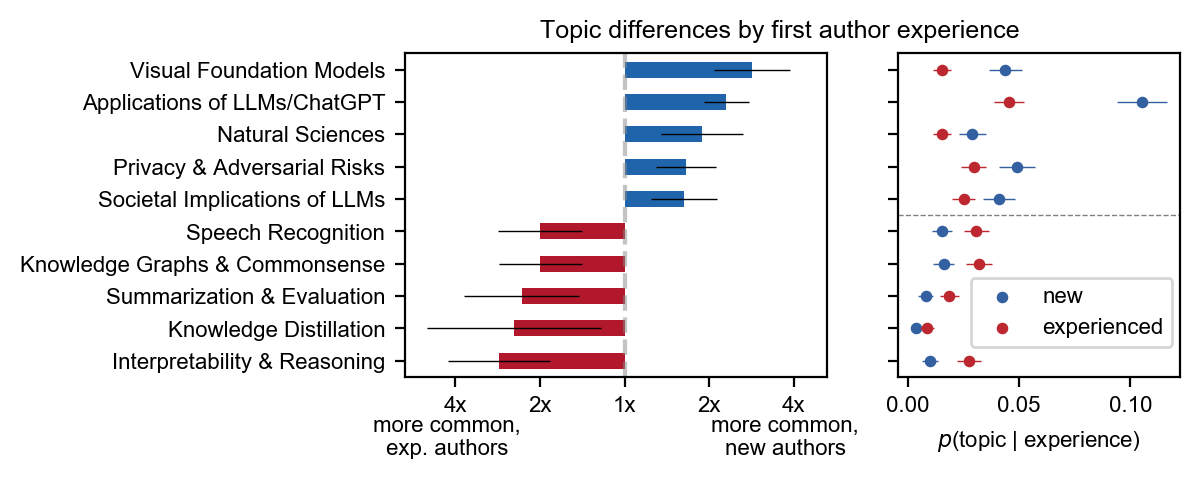

In [22]:
llm_df_2023 = llm_df[llm_df['v1_date'].dt.year == 2023]
# Compute enriched topics for new authors

first_author_experience_topic_df = utils.get_topic_counts_by_binary_variable(llm_df_2023, 'new_first_author', 'cluster')

f, (enrich_ax, dot_ax) = utils.enrichment_plot_and_dotplot(
    first_author_experience_topic_df,
    bar_names_col='topic',
    pos_label='more common,\nnew authors',
    neg_label='more common,\nexp. authors',
    true_label='new',
    false_label='experienced',
    legend_coords=(0.22, 0.34),
    width_ratios=(3, 2),
    dotplot_xlabel=r'$p$(topic | experience)',
    top_and_bottom_k=5,
    manual_enrichment_xlim=(2.6, 2.4),
    dpi=200,
)


f.suptitle("Topic differences by first author experience", y=0.96, fontsize=9)
f.savefig('./analysis/figures/topic_barplot_first_author_experience_priorNLP.pdf', bbox_inches='tight', dpi=300)

plt.show()

## Where are new authors coming from (what are their publication histories)?

In [176]:
# We're going to use this to see who had any paper(s) before their LLM paper

unique_auth_2023 = llm_df[(llm_df['v1_date'].dt.year == 2023)]['first_author'].unique()
auth_min_llmpaper_dates = llm_df[llm_df['v1_date'].dt.year == 2023].groupby('first_author')['v1_date'].min()
llm_authors_2023_first_llm_paper_date_dict = {
    auth : auth_min_llmpaper_dates[auth] for auth in unique_auth_2023
}

auth_min_anypaper_dates = arxiv_df.groupby('author')['v1_date'].min()
all_authors_first_paper_date_dict = {
    auth : auth_min_anypaper_dates[auth] for auth in arxiv_df['author'].unique()
}


In [199]:
new_authors_2023 = set(llm_df[(llm_df['v1_date'].dt.year == 2023) & (llm_df['new_first_author'] == True)]['first_author'].unique())
exp_authors_2023 = set(llm_df[(llm_df['v1_date'].dt.year == 2023) & (llm_df['new_first_author'] == False)]['first_author'].unique())
# If an author published their first paper in 2023 and *that* was the paper 
# qualifying them as experienced, then they should count as new.
exp_authors_2023 = exp_authors_2023 - new_authors_2023

# How many new authors in 2023 had any paper before their LLM paper?
n_new_authors_with_prior_paper = len([auth for auth in new_authors_2023 if auth in all_authors_first_paper_date_dict and all_authors_first_paper_date_dict[auth] < llm_authors_2023_first_llm_paper_date_dict[auth]])
print(f"# new 2023 authors with prior paper: {n_new_authors_with_prior_paper} / {len(new_authors_2023)} ({n_new_authors_with_prior_paper / len(new_authors_2023) * 100:.2f}%)")

# How many experienced authors in 2023 had any paper before their LLM paper? (should be 100%)
n_exp_authors_with_prior_paper = len([auth for auth in exp_authors_2023 if auth in all_authors_first_paper_date_dict and all_authors_first_paper_date_dict[auth] < llm_authors_2023_first_llm_paper_date_dict[auth]])
print(f"# exp 2023 authors with prior paper: {n_exp_authors_with_prior_paper} / {len(exp_authors_2023)} ({n_exp_authors_with_prior_paper / len(exp_authors_2023) * 100:.2f}%)")

new_author_prior_papers_df = arxiv_df[arxiv_df['author'].isin(new_authors_2023)]
new_author_prior_papers_df = new_author_prior_papers_df[new_author_prior_papers_df['v1_date'].dt.year < 2023]

exp_author_prior_papers_df = arxiv_df[arxiv_df['author'].isin(exp_authors_2023)]
exp_author_prior_papers_df = exp_author_prior_papers_df[exp_author_prior_papers_df['v1_date'].dt.year < 2023]
print("Total # of prior papers by new authors in 2023:", len(new_author_prior_papers_df))
print("Total # of prior papers by exp authors in 2023:", len(exp_author_prior_papers_df))

# new 2023 authors with prior paper: 1570 / 2746 (57.17%)
# exp 2023 authors with prior paper: 2796 / 2796 (100.00%)
Total # of prior papers by new authors in 2023: 9476
Total # of prior papers by exp authors in 2023: 51107


In [216]:
df_subarxiv_counts_prior_papers = {'subarxiv': [], 'new_author_count': [], 'exp_author_count': [], 'new_author_percent': [], 'exp_author_percent': []}

# all_subarxivs = set(new_author_prior_papers_df['first_category'].unique()) | set(exp_author_prior_papers_df['first_category'].unique())
# all
for subarxiv in SUBARXIV_NAMES_DICT.keys():
    new_author_count = len(new_author_prior_papers_df[new_author_prior_papers_df['first_category'] == subarxiv])
    exp_author_count = len(exp_author_prior_papers_df[exp_author_prior_papers_df['first_category'] == subarxiv])
    if new_author_count + exp_author_count < 50:
        continue
    df_subarxiv_counts_prior_papers['subarxiv'].append(subarxiv)
    df_subarxiv_counts_prior_papers['new_author_count'].append(new_author_count)
    df_subarxiv_counts_prior_papers['exp_author_count'].append(exp_author_count)
    df_subarxiv_counts_prior_papers['new_author_percent'].append(new_author_count / len(new_author_prior_papers_df) * 100)
    df_subarxiv_counts_prior_papers['exp_author_percent'].append(exp_author_count / len(exp_author_prior_papers_df) * 100)

df_subarxiv_counts_prior_papers = pd.DataFrame(df_subarxiv_counts_prior_papers)
df_subarxiv_counts_prior_papers = df_subarxiv_counts_prior_papers.sort_values('new_author_count', ascending=False)

# Add chi2 p-value comparing ratios for new vs exp authors
df_subarxiv_counts_prior_papers['p_chi2'] = df_subarxiv_counts_prior_papers.apply(lambda x: stats.chi2_contingency([[x['new_author_count'], x['exp_author_count']], [len(new_author_prior_papers_df), len(exp_author_prior_papers_df)]])[1], axis=1)

display(df_subarxiv_counts_prior_papers.head(25))

,subarxiv,new_author_count,exp_author_count,new_author_percent,exp_author_percent,p_chi2
7,cs.CV,2876,10572,30.350,20.686,1.117e-58
19,cs.LG,1978,7881,20.874,15.421,3.096e-28
29,cs.SE,361,761,3.810,1.489,1.577e-50
18,cs.IT,351,1937,3.704,3.790,7.195e-01
27,cs.RO,332,1065,3.504,2.084,2.651e-16
6,cs.CR,296,1119,3.124,2.190,8.864e-08
0,cs.AI,247,1191,2.607,2.330,1.221e-01
30,cs.SI,221,712,2.332,1.393,2.980e-11
17,cs.IR,200,1570,2.111,3.072,7.826e-07
35,stat.ML,174,789,1.836,1.544,4.437e-02


In [227]:
n_rows = 10

# Print out a latex table of the subarxiv counts
latex_df = df_subarxiv_counts_prior_papers[['subarxiv', 
                                            'new_author_percent', 
                                            'exp_author_percent', 
                                            'p_chi2',
                                            ]].sort_values(by='new_author_percent', ascending=False).head(n_rows).copy()

# Convert table to latex
# Use different float format for each column
float_format = {'new_author_percent': '{:,.1f}'.format,
                'exp_author_percent': '{:,.1f}'.format,
                'subarxiv': lambda x: SUBARXIV_NAMES_DICT[x],
                # 'p_chi2': '{:.1e}'.format,
                }

# Apply string formatting to each column
formatted_df = latex_df.copy()
for column, format_spec in float_format.items():
    formatted_df[column] = formatted_df[column].apply(format_spec)

# For each row, if the p-value is less than 1e-3, bold the larger value of the two. Then drop the p-value column.
for index, row in formatted_df.iterrows():
    if row['p_chi2'] < 1e-3:
        if row['new_author_percent'] > row['exp_author_percent']:
            formatted_df.loc[index, 'new_author_percent'] = '\textbf{' + formatted_df.loc[index, 'new_author_percent'] + '}'
        else:
            formatted_df.loc[index, 'exp_author_percent'] = '\textbf{' + formatted_df.loc[index, 'exp_author_percent'] + '}'
formatted_df.drop('p_chi2', axis=1, inplace=True)

# # Make the 'size' column the 2nd column
# cols = formatted_df.columns.tolist()
# cols = cols[:1] + cols[-1:] + cols[1:-1]
# formatted_df = formatted_df[cols]


formatted_df = formatted_df.rename(columns={'subarxiv': 'sub-arXiv', 
                                    'new_author_percent': r'% new', 
                                    'exp_author_percent': r'% experienced', 
                                    # 'p_chi2': r'$p$-value',
                                    })

# Convert the formatted DataFrame to LaTeX
# Use styler
latex_table = formatted_df.to_latex(index=False, escape=False, column_format='lccc', bold_rows=True)
print(latex_table)

\begin{tabular}{lccc}
\toprule
                sub-arXiv &         % new & % experienced \\
\midrule
          Computer Vision & \textbf{30.4} &          20.7 \\
         Machine Learning & \textbf{20.9} &          15.4 \\
     Software Engineering &  \textbf{3.8} &           1.5 \\
       Information Theory &           3.7 &           3.8 \\
                 Robotics &  \textbf{3.5} &           2.1 \\
Cryptography and Security &  \textbf{3.1} &           2.2 \\
  Artificial Intelligence &           2.6 &           2.3 \\
Social and Info. Networks &  \textbf{2.3} &           1.4 \\
    Information Retrieval &           2.1 &  \textbf{3.1} \\
                Stat - ML &           1.8 &           1.5 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2023530/3545673879.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = formatted_df.to_latex(index=False, escape=False, column_format='lccc', bold_rows=True)
